# Energy Consumption: Forecasting & Anomaly Detection


## 1. Introduction & Motivation

Accurate forecasting and anomaly detection in energy consumption data are critical for both consumers and providers. Understanding and predicting patterns in household electricity usage can help to optimize energy distribution, detect unusual events (such as faulty appliances or unexpected consumption spikes), and support sustainability efforts by promoting smarter usage.

This project focuses on analyzing and modeling a real-world dataset of household power consumption. By applying classic time series forecasting techniques and machine learning–based anomaly detection, we aim to answer two core questions:

1. **How well can we predict future electricity consumption based on past behavior?**
2. **Can we automatically detect unusual or suspicious consumption patterns in the data?**

These tasks are directly relevant to applications in smart grids, predictive maintenance, and energy management systems. The project serves as a hands-on example of modern data science for time series analysis and demonstrates practical skills in cleaning, visualizing, and modeling complex real-world data.


## 2. Data Loading & Cleaning

Before any meaningful analysis can be performed, it is essential to ensure the dataset is clean, well-structured, and ready for modeling. In this section, we will load the raw electricity consumption data, combine date and time information into a single datetime index, convert relevant columns to appropriate numeric types, and handle missing or invalid values. These preprocessing steps are crucial for accurate time series forecasting and anomaly detection, as they help to minimize bias and prevent errors during the modeling phase.


### 2.1 Importing the Dataset and Creating the Datetime Index

In [4]:
import pandas as pd

# 1. Load the CSV file WITHOUT parse_dates
df = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    na_values='?',
    low_memory=False
)

# 2. Create a Datetime column from Date + Time
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# 3. Set the Datetime column as index (useful for time series analysis)
df.set_index('Datetime', inplace=True)

# 4. Check column data types and preview the first rows
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 158.3+ MB


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### 2.2 Conversion of All Measurements to Numeric Types

In [6]:
for col in df.columns:
    if col not in ['Date', 'Time']:
        df[col] = pd.to_numeric(df[col], errors='coerce')


### 2.3 Analysis of Missing Data in the Dataset

In [7]:
# Count total rows
total_rows = len(df)

# Count total columns (excluding index)
total_columns = len(df.columns)

# Count total values in the dataset (rows * columns)
total_values = total_rows * total_columns

# Count rows with at least one missing value
num_missing_rows = df.isna().any(axis=1).sum()

# Calculate percentage of affected rows
percent_missing_rows = (num_missing_rows / total_rows) * 100

# Count total missing values in the entire DataFrame
total_missing_values = df.isna().sum().sum()

# Calculate percentage of missing values in the entire dataset
percent_missing_values = (total_missing_values / total_values) * 100

# Print results
print(f"Total rows: {total_rows}")
print(f"Total columns: {total_columns}")
print(f"Total values in the dataset: {total_values}")
print(f"Total missing values in the dataset: {total_missing_values}")
print(f"Percentage of missing values in the dataset: {percent_missing_values:.2f}%")
print(f"Rows with at least one missing value: {num_missing_rows}")
print(f"Percentage of affected rows: {percent_missing_rows:.2f}%")



Total rows: 2075259
Total columns: 9
Total values in the dataset: 18677331
Total missing values in the dataset: 181853
Percentage of missing values in the dataset: 0.97%
Rows with at least one missing value: 25979
Percentage of affected rows: 1.25%


### 2.4 Handling Missing Values: Dropping Incomplete Rows

To ensure a clean and consistent time series dataset, all rows containing at least one missing value were removed using `dropna()`. Since only 1.25% of the data was affected, this approach prevents the introduction of artificial values and simplifies further modeling. This prepares the dataset for robust forecasting and anomaly detection in the following steps.


In [5]:
# Remove rows with any missing values
df_clean = df.dropna()

print(f"Original dataset size: {df.shape}")
print(f"Dataset size after dropna: {df_clean.shape}")
print(f"Removed {df.shape[0] - df_clean.shape[0]} rows ({100 * (df.shape[0] - df_clean.shape[0]) / df.shape[0]:.2f}%)")


Original dataset size: (2075259, 9)
Dataset size after dropna: (2049280, 9)
Removed 25979 rows (1.25%)


### 3. Exploratory Data Analysis (EDA)

In this section, we perform an exploratory analysis of the energy consumption dataset to gain a comprehensive understanding of its structure and characteristics. The goal of EDA is to uncover underlying patterns, detect potential anomalies, and identify trends or seasonality in the data. 

Key steps include examining the time range and sampling frequency, visualizing key variables, exploring the distribution of values, checking for outliers, and analyzing correlations between different measurements. This analysis provides valuable insights and guides the selection and configuration of forecasting and anomaly detection models in the following stages.


#### 3.1 Dataset Overview

Let's start by getting a basic overview of the dataset: its dimensions, the time range it covers, and a preview of the first few rows.


In [5]:
# Show the dimensions of the dataset
print(f"Number of rows: {df_clean.shape[0]}")
print(f"Number of columns: {df_clean.shape[1]}")

# Show the time range of the measurements
print(f"Time range: {df_clean.index.min()}  to  {df_clean.index.max()}")

# Show a preview of the data
df_clean.head()


Number of rows: 2049280
Number of columns: 9
Time range: 2006-12-16 17:24:00  to  2010-11-26 21:02:00


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


The cleaned dataset contains **2049280 rows** and **9 columns**, covering the period from **2006-12-16** to **2010-11-26**.  
Above, you can see a preview of the first few rows.  
This provides a quick overview of the data structure and the time span of the recorded energy consumption measurements.


#### 3.2 Analysis of the Datetime Index

Let's check whether the datetime index is continuous, the frequency is as expected (one entry per minute), and if there are any gaps or duplicate timestamps.


In [10]:
# Check if the datetime index is sorted
is_sorted = df_clean.index.is_monotonic_increasing
print(f"Datetime index is sorted: {is_sorted}")

# Check for duplicate timestamps
num_duplicates = df_clean.index.duplicated().sum()
print(f"Number of duplicate timestamps: {num_duplicates}")

# Generate the expected full datetime range
full_range = pd.date_range(start=df_clean.index.min(), end=df_clean.index.max(), freq="min")
print(f"Expected number of timestamps (1 per minute): {len(full_range)}")
print(f"Actual number of timestamps: {df_clean.shape[0]}")

# Find missing timestamps
missing_timestamps = full_range.difference(df_clean.index)
print(f"Number of missing timestamps: {len(missing_timestamps)}")
if len(missing_timestamps) > 0:
    print("First 5 missing timestamps:", missing_timestamps[:5])
else:
    print("No missing timestamps in the index.")


Datetime index is sorted: True
Number of duplicate timestamps: 0
Expected number of timestamps (1 per minute): 2075259
Actual number of timestamps: 2049280
Number of missing timestamps: 25979
First 5 missing timestamps: DatetimeIndex(['2006-12-21 11:23:00', '2006-12-21 11:24:00',
               '2006-12-30 10:08:00', '2006-12-30 10:09:00',
               '2007-01-14 18:36:00'],
              dtype='datetime64[ns]', freq=None)


#### 3.3 Overview of Features

Let's review the columns present in the dataset, including their names, data types, and a brief description of what each variable represents.


In [11]:
# Show column names and data types
df_clean.info()

# Optionally: Show the first few rows again to get a sense of the data values
df_clean.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 220.8+ MB


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


| Column Name            | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| date, time             | Date and time of measurement (combined into datetime index)                  |
| global_active_power    | Total household active power usage (kilowatts, minute-averaged)             |
| global_reactive_power  | Total household reactive power (kilowatts, minute-averaged)                 |
| voltage                | Voltage (volts, minute-averaged)                                            |
| global_intensity       | Current intensity (amperes, minute-averaged)                                |
| sub_metering_1         | Energy usage for kitchen appliances (watt-hour)                             |
| sub_metering_2         | Energy usage for laundry room appliances (watt-hour)                        |
| sub_metering_3         | Energy usage for water heater and air conditioner (watt-hour)               |


**Note:**  
`(global_active_power * 1000 / 60 - sub_metering_1 - sub_metering_2 - sub_metering_3)`  
represents the active energy consumed every minute (in watt-hour) by electrical equipment in the household **that is not measured by sub_metering_1, sub_metering_2, or sub_metering_3**.  
In other words, this value accounts for the residual energy usage from all other devices and appliances not included in the three sub-meterings.



#### 3.4 Visualizing Missing Values

Understanding the presence and distribution of missing values is essential in any data analysis workflow. In this section, we visualize missing data across different columns and over time to identify patterns, gaps, or systematic issues in the dataset. Recognizing when and where data is missing helps to decide on appropriate strategies for handling these gaps and ensures the quality and reliability of subsequent analyses and modeling.


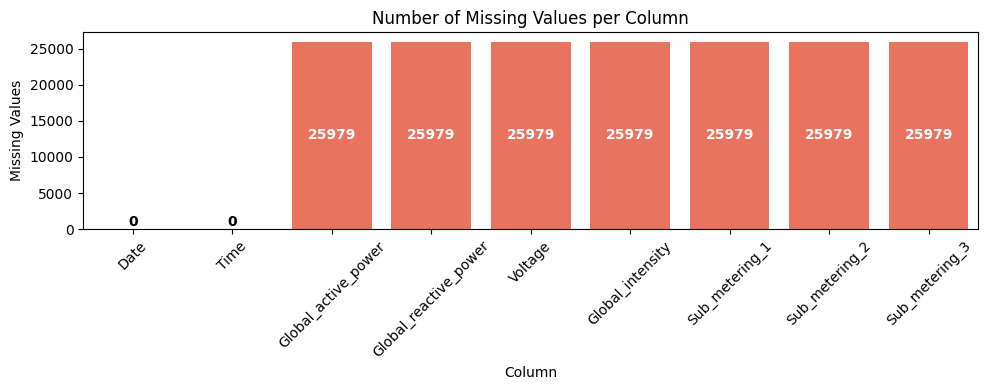

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count missing values per column
missing_counts = df.isna().sum()

plt.figure(figsize=(10, 4))
ax = sns.barplot(x=missing_counts.index, y=missing_counts.values, color='tomato')
plt.title("Number of Missing Values per Column")
plt.ylabel("Missing Values")
plt.xlabel("Column")
plt.xticks(rotation=45)
plt.tight_layout()

# Add value labels: on top if value is 0, centered otherwise
for i, v in enumerate(missing_counts.values):
    if v == 0:
        ax.text(i, 0.5, '0', ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')
    else:
        ax.text(i, v / 2, str(v), ha='center', va='center', color='white', fontsize=10, fontweight='bold')

plt.show()



In [ ]:
!pip install missingno


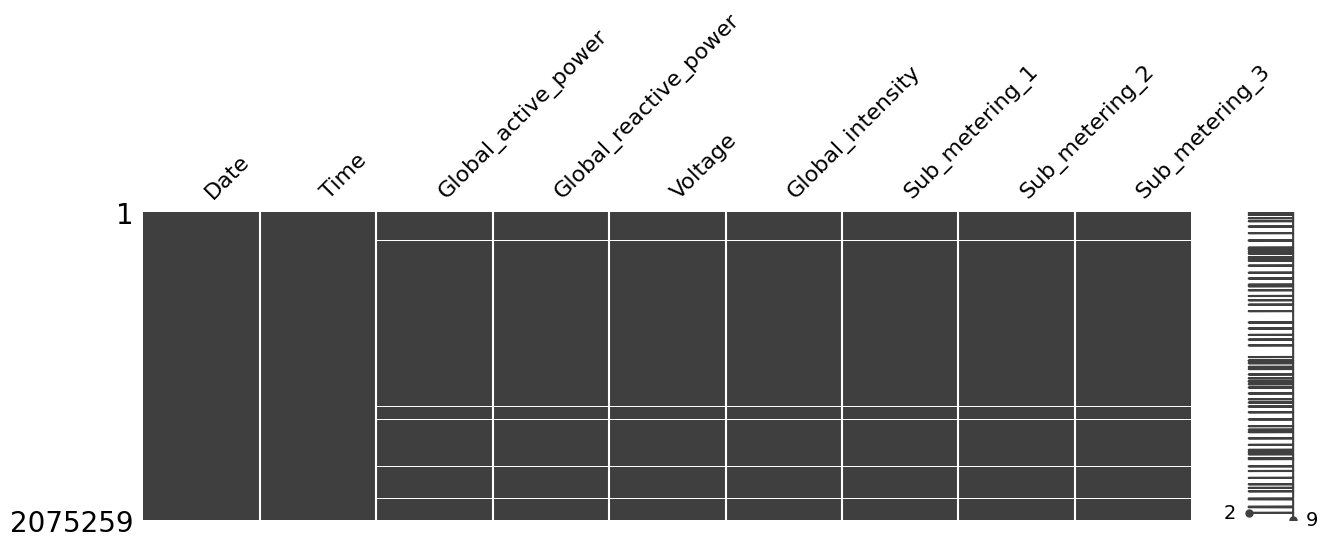

In [36]:
import missingno as msno
import matplotlib.pyplot as plt

# Visualize missing values as a matrix (timeline)
msno.matrix(df, figsize=(15,4))
plt.show()

In [13]:
import pandas as pd

# Mark rows with at least one missing value
missing_per_timestep = df.isna().any(axis=1)

# Find transitions: start and end of gaps
missing_periods = missing_per_timestep.astype(int).diff().fillna(0)

# Indices where a gap starts (transition from 0 to 1)
gap_starts = missing_periods[missing_periods == 1].index

# Indices where a gap ends (transition from 1 to 0)
gap_ends = missing_periods[missing_periods == -1].index

# If the last gap runs until the end of the dataset
if len(gap_ends) < len(gap_starts):
    gap_ends = gap_ends.append(pd.Index([missing_per_timestep.index[-1]]))

# DataFrame with start, end, and duration of each gap
gaps = pd.DataFrame({
    'Start': gap_starts,
    'End': gap_ends
})

# Duration of each gap (as timedelta)
gaps['Duration'] = (pd.to_datetime(gaps['End']) - pd.to_datetime(gaps['Start']))

# Format datetime columns for nicer display
gaps['Start'] = pd.to_datetime(gaps['Start']).dt.strftime('%Y-%m-%d %H:%M:%S')
gaps['End'] = pd.to_datetime(gaps['End']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Make columns wider in the display (for Jupyter Notebooks)
pd.set_option('display.max_colwidth', None)
# Show ALL rows in DataFrame output (use with caution for large DataFrames!)
pd.set_option('display.max_rows', None)
print(gaps)



                  Start                  End        Duration
0   2006-12-21 11:23:00  2006-12-21 11:25:00 0 days 00:02:00
1   2006-12-30 10:08:00  2006-12-30 10:10:00 0 days 00:02:00
2   2007-01-14 18:36:00  2007-01-14 18:37:00 0 days 00:01:00
3   2007-01-28 17:13:00  2007-01-28 17:14:00 0 days 00:01:00
4   2007-02-22 22:58:00  2007-02-22 23:00:00 0 days 00:02:00
5   2007-03-25 17:52:00  2007-03-25 17:53:00 0 days 00:01:00
6   2007-04-28 00:21:00  2007-04-30 14:24:00 2 days 14:03:00
7   2007-06-01 19:14:00  2007-06-01 19:15:00 0 days 00:01:00
8   2007-06-06 21:56:00  2007-06-06 21:57:00 0 days 00:01:00
9   2007-06-09 11:44:00  2007-06-09 11:45:00 0 days 00:01:00
10  2007-06-09 12:05:00  2007-06-09 12:06:00 0 days 00:01:00
11  2007-06-09 17:55:00  2007-06-09 17:58:00 0 days 00:03:00
12  2007-06-09 17:59:00  2007-06-09 18:32:00 0 days 00:33:00
13  2007-06-19 12:14:00  2007-06-19 12:16:00 0 days 00:02:00
14  2007-06-29 09:59:00  2007-06-29 10:00:00 0 days 00:01:00
15  2007-07-15 16:49:00 

**Conclusion for Section 3.4: Missing Values**

A total of **25,979 rows (minutes)** were not recorded in the dataset. In all cases, entire rows are missing — there are never isolated missing values within a row. Most data gaps span only a few minutes, but there are also isolated instances where data is missing for up to 5 consecutive days. This pattern suggests that missingness is caused primarily by interruptions in data collection rather than sporadic sensor failures.


#### 3.5 Basic Visualizations

In this section, we use a variety of plots to explore the main characteristics of the household energy consumption data. Visualizing the data helps to reveal underlying patterns, identify peaks and troughs in consumption, and gain an intuitive understanding of different energy usage components over time. 

We begin by plotting the total energy consumption (`Global_active_power`) across the entire period, as well as zooming in on shorter time intervals to observe daily and weekly patterns. Next, we compare the energy usage in different areas of the household by visualizing the sub-metering data. Finally, we examine the distribution of the key variables using histograms and boxplots, which help to highlight typical values, variability, and possible outliers in the measurements.


##### 3.5.1 Global Active Power over Time

We start by visualizing the total household energy consumption (`Global_active_power`) over the entire recorded period. Due to the large number of data points, we also zoom in on a one-week period to better observe daily usage patterns.


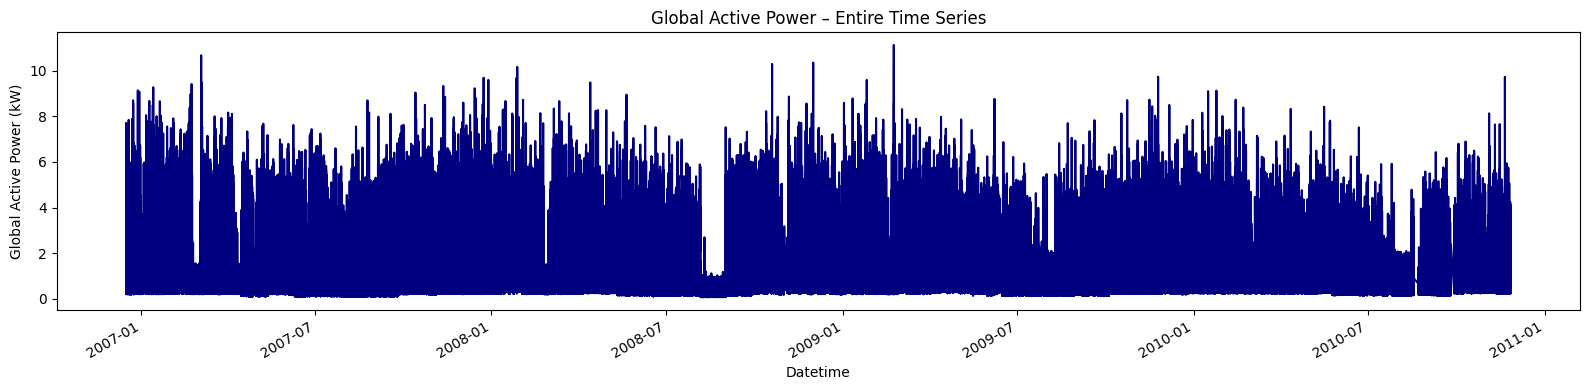

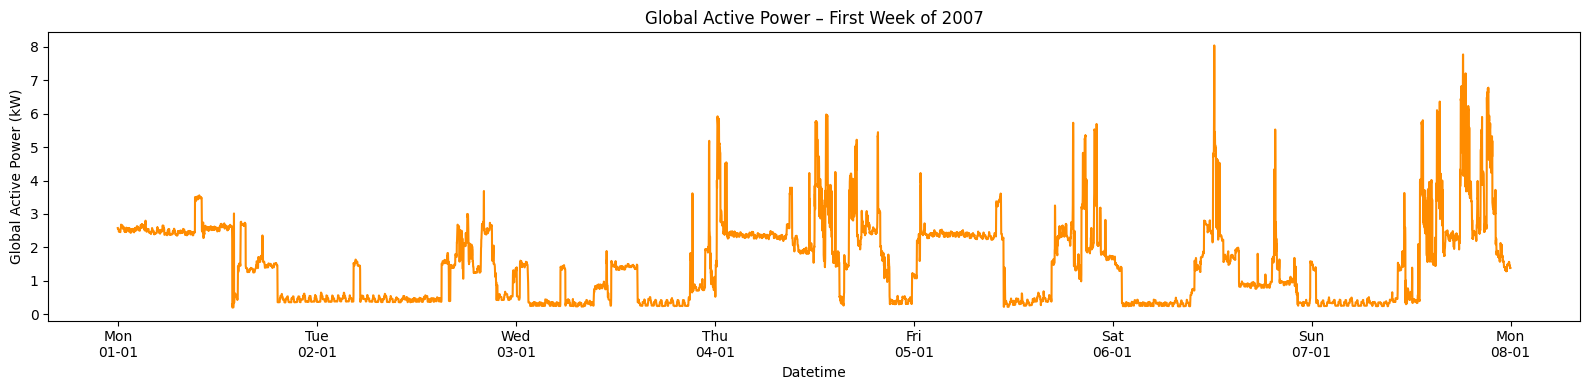

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Entire time series: Global Active Power
plt.figure(figsize=(16, 4))
df_clean['Global_active_power'].plot(color='navy')
plt.title('Global Active Power – Entire Time Series')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.tight_layout()
plt.show()

# One week excerpt
start, end = '2007-01-01', '2007-01-07'
data_week = df_clean[start:end]['Global_active_power']

plt.figure(figsize=(16, 4))
plt.plot(data_week.index, data_week.values, color='darkorange')

plt.title('Global Active Power – First Week of 2007')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')

# Format x-axis with weekday names
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d-%m'))

plt.tight_layout()
plt.show()





##### 3.5.2 Monthly Average of Global Active Power

To better understand long-term trends and seasonal effects in household energy consumption, we calculate and visualize the monthly average of `Global_active_power`. Aggregating the data by month smooths out short-term fluctuations and highlights broader patterns, such as increases or decreases in energy usage throughout the year.


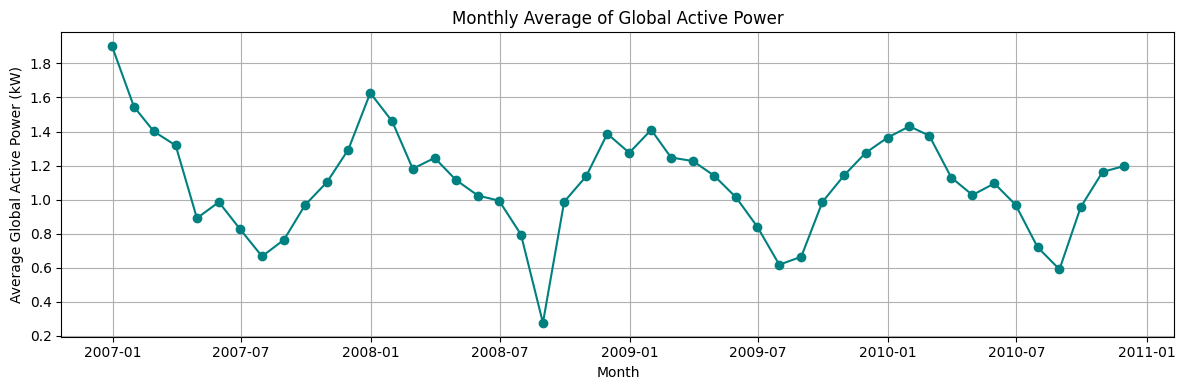

In [14]:
import matplotlib.pyplot as plt

# Resample to monthly average
monthly_avg = df_clean['Global_active_power'].resample('ME').mean()

plt.figure(figsize=(12, 4))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', color='teal')
plt.title('Monthly Average of Global Active Power')
plt.xlabel('Month')
plt.ylabel('Average Global Active Power (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()


##### 3.5.3 Comparison of Sub-Meterings Over One Week

To analyze how different areas and appliances contribute to total household energy consumption, we compare the three sub-metering variables over the same time period. Each sub-metering represents energy usage for a specific group of appliances: the kitchen, the laundry room, and the water heater/air conditioner. Plotting them together for a typical week reveals differences in usage patterns and highlights peak consumption periods for each category.


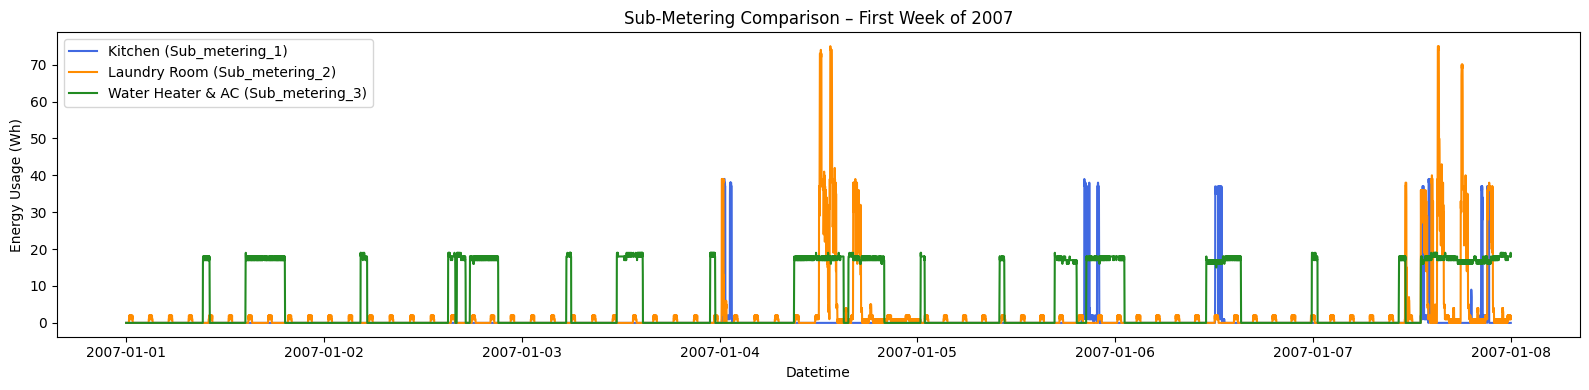

In [52]:
import matplotlib.pyplot as plt

# Choose a week (e.g., first week of 2007)
start, end = '2007-01-01', '2007-01-07'
data_week = df_clean.loc[start:end, ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

plt.figure(figsize=(16, 4))
plt.plot(data_week.index, data_week['Sub_metering_1'], label='Kitchen (Sub_metering_1)', color='royalblue')
plt.plot(data_week.index, data_week['Sub_metering_2'], label='Laundry Room (Sub_metering_2)', color='darkorange')
plt.plot(data_week.index, data_week['Sub_metering_3'], label='Water Heater & AC (Sub_metering_3)', color='forestgreen')

plt.title('Sub-Metering Comparison – First Week of 2007')
plt.xlabel('Datetime')
plt.ylabel('Energy Usage (Wh)')
plt.legend()
plt.tight_layout()
plt.show()


By inspecting the plot, we can clearly identify distinct peaks in the laundry room sub-metering, which likely correspond to periods when the washing machine or tumble dryer is in use. These sharp increases stand out from the background consumption and provide insight into the timing and frequency of laundry activities.


##### 3.5.4 Distribution of Global Active Power

To better understand the overall consumption patterns and identify typical values as well as possible outliers, we visualize the distribution of `Global_active_power` using a histogram. This plot helps reveal how household energy usage is distributed across the entire observation period and highlights whether certain power levels are especially common or rare.


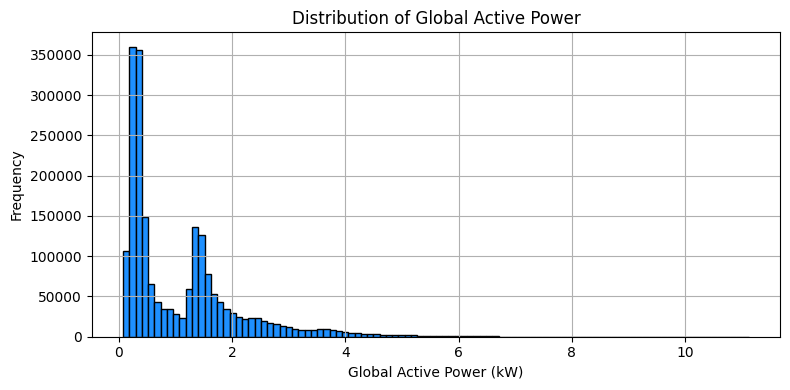

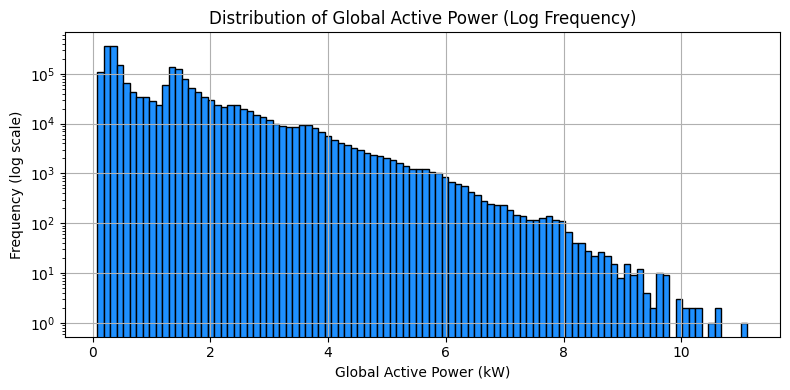

In [55]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,4))
df_clean['Global_active_power'].hist(bins=100, color='dodgerblue', edgecolor='black')
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kW)')    # X-Achse: Verbrauch in kW
plt.ylabel('Frequency')                   # Y-Achse: Wie oft kam dieser Verbrauch vor?
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,4))
df_clean['Global_active_power'].hist(bins=100, color='dodgerblue', edgecolor='black')
plt.yscale('log')
plt.title('Distribution of Global Active Power (Log Frequency)')
plt.xlabel('Global Active Power (kW)')
plt.ylabel('Frequency (log scale)')
plt.tight_layout()
plt.show()


In [59]:
# Select the Global_active_power column (without missing values)
values = df_clean['Global_active_power']

# Calculate the percentage of values between 0 and 1 kW
percent_0_1 = ((values >= 0) & (values < 1)).mean() * 100

print(f"{percent_0_1:.2f}% of all measured values are between 0 and 1 kW.")
# Calculate the percentage of values between 0 and 2 kW
percent_0_2 = ((values >= 0) & (values < 2)).mean() * 100

print(f"{percent_0_2:.2f}% of all measured values are between 0 and 2 kW.")



56.64% of all measured values are between 0 and 1 kW.
85.04% of all measured values are between 0 and 2 kW.


**Conclusion: Distribution of Global Active Power**

The histogram reveals that energy consumption is highly concentrated at lower power levels. Specifically, **56.64%** of all measured values are between 0 and 1 kW, and **85.04%** fall between 0 and 2 kW. This indicates that most household power usage remains relatively modest, with higher consumption values occurring much less frequently. 

It is likely that the highest consumption values are only reached when energy-intensive appliances such as the air conditioner, washing machine, or tumble dryer are operating.


##### 3.5.5 Boxplot of Global Active Power and Sub-Meterings

To summarize the distribution and detect potential outliers in energy usage, we visualize `Global_active_power` and the three sub-metering variables with boxplots. These plots provide a compact overview of the typical range, variability, and extreme values for each measurement, making it easy to compare patterns across different categories of household appliances.


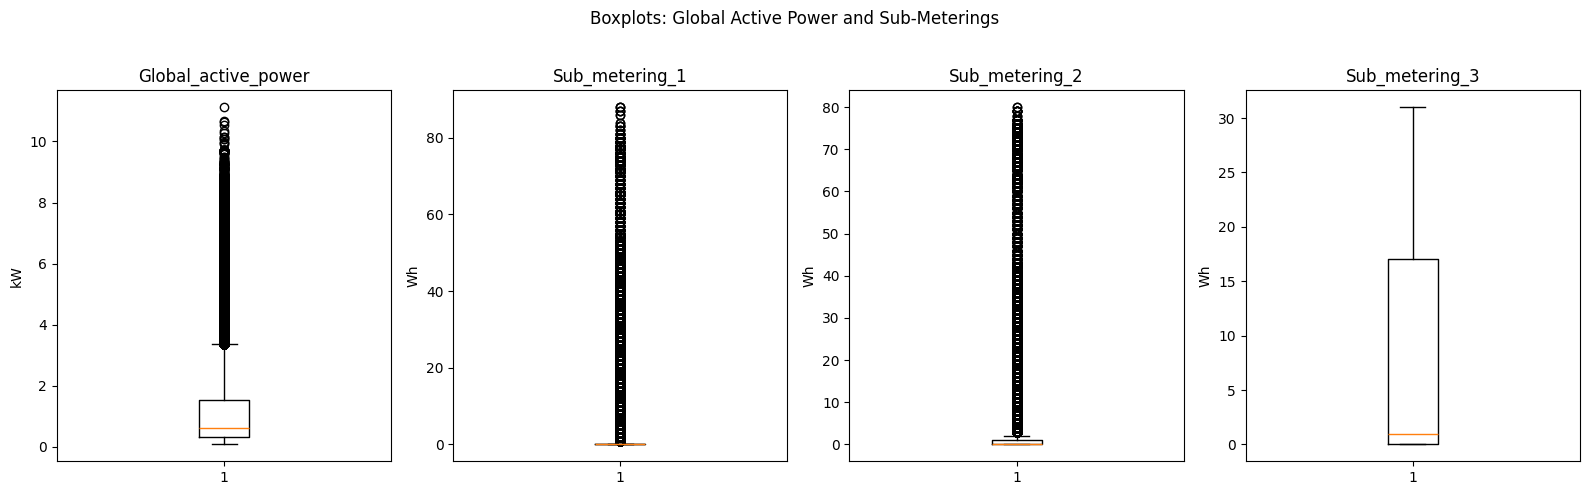

In [63]:
import matplotlib.pyplot as plt

# Select columns to compare
columns = ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Create separate boxplots for each variable
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for i, col in enumerate(columns):
    axes[i].boxplot(df_clean[col].dropna())
    axes[i].set_title(col)
    # Set appropriate y-label for each subplot
    if i == 0:
        axes[i].set_ylabel('kW')
    else:
        axes[i].set_ylabel('Wh')

plt.suptitle('Boxplots: Global Active Power and Sub-Meterings')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



**How to interpret the boxplots:**

- The **box** represents the interquartile range (IQR), which covers the middle 50% of all observed values (from the 25th to the 75th percentile).
- The **orange line inside the box** marks the **median** (the 50th percentile), representing the typical value.
- The **black "whiskers"** extend from the box to the smallest and largest values that are not considered outliers (usually up to 1.5 × IQR from the box).
- **Black dots** outside the whiskers are **outliers**, i.e., values that are unusually high or low compared to the rest of the data.
- **Single black horizontal lines outside the box** also indicate outliers that occur only once at that value.

Together, these boxplots provide a compact summary of the typical range, variability, and extreme values for each variable.


##### 3.5.6 Scatterplot: Global Active Power vs. Voltage

To investigate the relationship between total household power consumption and the voltage supplied to the house, we visualize a scatterplot of `Global_active_power` versus `Voltage`. This plot helps to reveal whether there is any correlation between the two variables, such as lower voltages during periods of high consumption or vice versa.


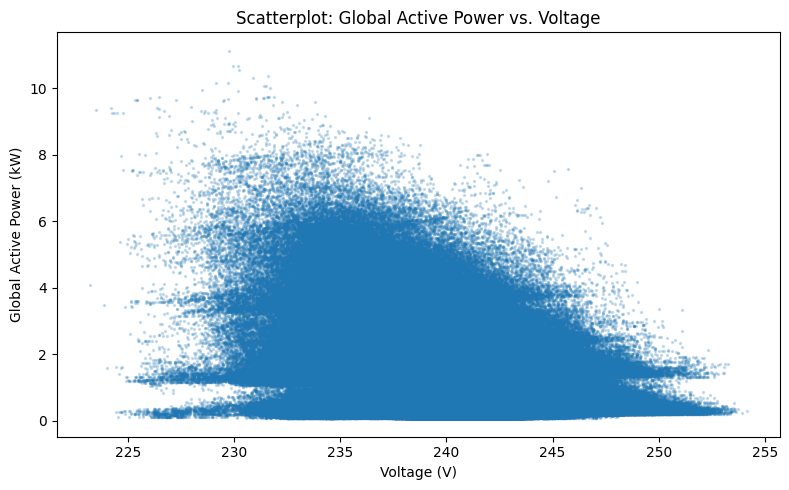

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(df_clean['Voltage'], df_clean['Global_active_power'], alpha=0.2, s=2)
plt.title('Scatterplot: Global Active Power vs. Voltage')
plt.xlabel('Voltage (V)')
plt.ylabel('Global Active Power (kW)')
plt.tight_layout()
plt.show()


The scatterplot reveals a slight tendency for higher power consumption values to be associated with slightly lower voltage readings. However, this relationship is not particularly strong or significant. This minor inverse trend is expected, as increased household demand can cause small, temporary voltage drops. Nevertheless, the voltage generally remains close to the standard value of 230 V (±10%), which is typical for European households and indicates a well-regulated local power grid.



##### 3.5.6 Heatmap: Average Global Active Power by Weekday and Time of Day

To gain more insight into daily and weekly consumption patterns, we categorize each measurement according to both the day of the week and the time of day (morning, afternoon, evening, or night). The following heatmap visualizes the average energy consumption for each combination of weekday and time window. This approach makes it easy to identify when the highest and lowest consumption typically occur throughout a typical week.


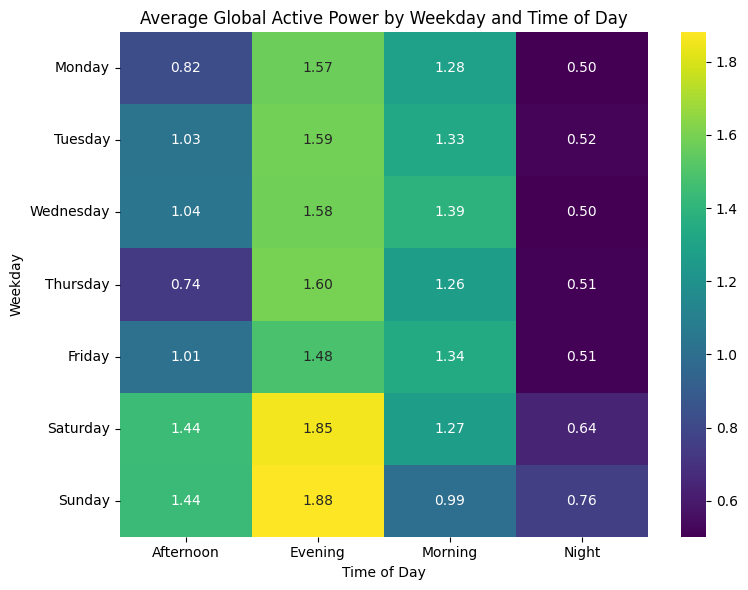

In [67]:
import numpy as np

# Function to categorize hour into a time of day
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 23:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create a new 'Time_of_day' column
df_clean.loc[:, 'Time_of_day'] = df_clean.index.hour.map(get_time_of_day)
# Add a 'Weekday' column with the name of the day
df_clean.loc[:, 'Weekday'] = df_clean.index.day_name()

# Create a pivot table with average Global Active Power by weekday and time of day
pivot = df_clean.pivot_table(
    values='Global_active_power',
    index='Weekday',       # rows: weekday
    columns='Time_of_day', # columns: time of day
    aggfunc='mean'
)

# Optional: set the order of weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = pivot.reindex(weekday_order)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='viridis')
plt.title('Average Global Active Power by Weekday and Time of Day')
plt.ylabel('Weekday')
plt.xlabel('Time of Day')
plt.tight_layout()
plt.show()


**Summary:**  
The heatmap clearly shows that energy consumption is highest on weekends during the afternoon and evening hours, while it is lowest at night throughout the entire week. This suggests increased household activity and appliance usage during weekend afternoons and evenings, with minimal consumption during nighttime periods.


##### 3.5.7 Barplot: Average Global Active Power by Weekday or Month

To highlight broader temporal patterns in household energy usage, we calculate and visualize the average power consumption for each weekday and for each month. These barplots help to reveal trends such as whether certain days of the week or particular months are associated with higher or lower average energy demand, which may reflect routine behaviors or seasonal effects.


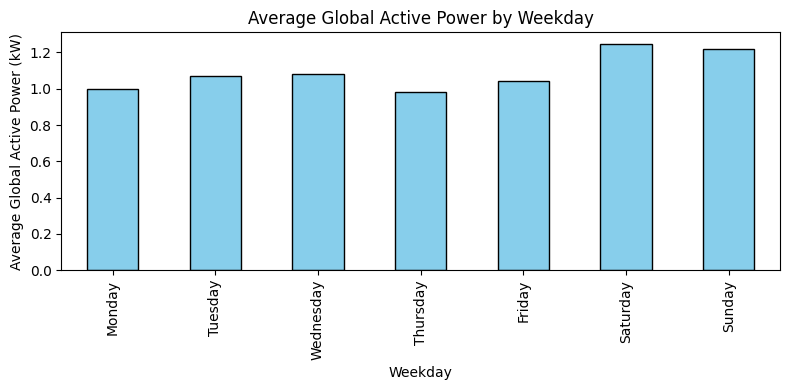

In [70]:
import matplotlib.pyplot as plt

# Calculate the average Global_active_power for each weekday
weekday_avg = df_clean.groupby(df_clean.index.day_name())['Global_active_power'].mean()

# Ensure the weekdays are ordered from Monday to Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_avg = weekday_avg.reindex(weekday_order)

# Barplot for weekdays
plt.figure(figsize=(8, 4))
weekday_avg.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Global Active Power by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Global Active Power (kW)')
plt.tight_layout()
plt.show()


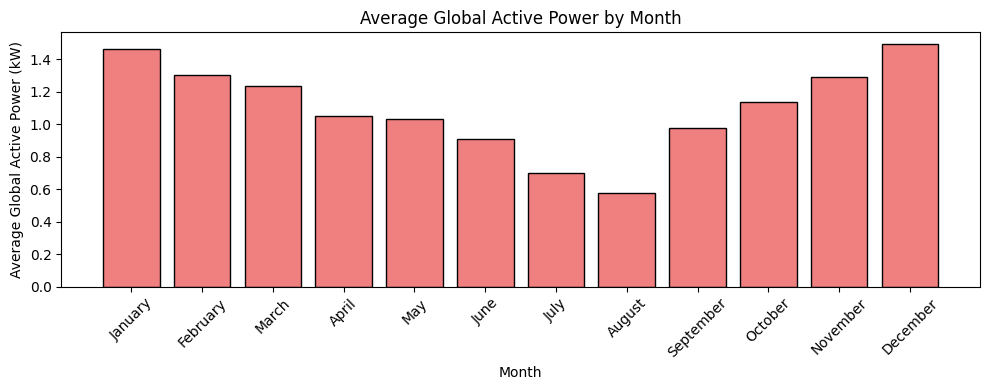

In [71]:
# Calculate the average Global_active_power for each month
month_avg = df_clean.groupby(df_clean.index.month)['Global_active_power'].mean()

# Month names for better readability
import calendar
month_names = [calendar.month_name[m] for m in month_avg.index]

# Barplot for months
plt.figure(figsize=(10, 4))
plt.bar(month_names, month_avg, color='lightcoral', edgecolor='black')
plt.title('Average Global Active Power by Month')
plt.xlabel('Month')
plt.ylabel('Average Global Active Power (kW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Note:**  
Although the official dataset description states that `sub_metering_3` corresponds to "an electric water heater and an air-conditioner", the strong increase in energy consumption during winter months suggests that this sub-metering is primarily tracking heating or hot water usage, rather than air conditioning. This pattern aligns with typical European household energy consumption, where electric heating and water heaters are common, but air conditioning is rarely used.


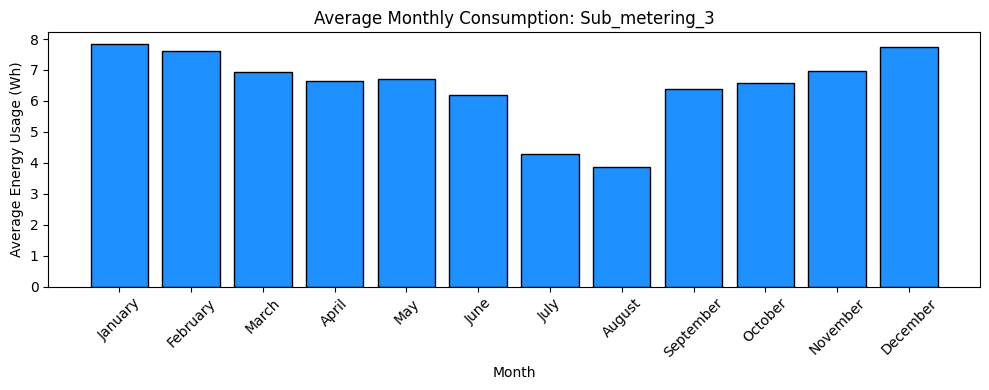

In [74]:
import matplotlib.pyplot as plt
import calendar

# Calculate the monthly average for sub_metering_3
monthly_avg_sm3 = df_clean['Sub_metering_3'].resample('ME').mean()

# Month numbers (1–12) für Gruppierung
monthly_avg_by_month = monthly_avg_sm3.groupby(monthly_avg_sm3.index.month).mean()
month_names = [calendar.month_name[m] for m in monthly_avg_by_month.index]

# Barplot
plt.figure(figsize=(10, 4))
plt.bar(month_names, monthly_avg_by_month, color='dodgerblue', edgecolor='black')
plt.title('Average Monthly Consumption: Sub_metering_3')
plt.xlabel('Month')
plt.ylabel('Average Energy Usage (Wh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Interpretation:**  
The plot clearly supports the hypothesis that `sub_metering_3` primarily measures heating or hot water usage rather than air conditioning. The average monthly consumption is significantly higher during the winter months and much lower in the summer, which is characteristic of electric heating or water heaters in European households. This seasonal pattern would be unlikely if air conditioning were the main contributor, as AC usage typically peaks during the summer.


#### 4. Forecasting Models

In this section, we develop and compare several approaches for forecasting future household electricity consumption. Accurate time series forecasting enables energy providers and consumers to anticipate demand, optimize resource allocation, and detect emerging patterns or shifts in usage.

We implement and evaluate three distinct types of forecasting models:

- **ARIMA:** A classical statistical method that models the autocorrelations in the data and is well suited for stationary time series.
- **SARIMA:** An extension of the classical ARIMA model that incorporates both non-seasonal and seasonal components, making it well suited for time series with repeating seasonal patterns.
- **Prophet:** A flexible model developed by Facebook that automatically detects and fits trend and seasonality components, making it ideal for time series with complex seasonal patterns.
- **LSTM Neural Network:** A modern machine learning approach based on recurrent neural networks, capable of capturing long-term dependencies and nonlinear relationships in sequential data.

By applying these models to the household power consumption data, we aim to assess their predictive performance and practical applicability for real-world energy forecasting.


### 4.1 ARIMA Model

The ARIMA model (AutoRegressive Integrated Moving Average) is a classical approach for time series forecasting. It predicts future values based on past observations by combining three key components: autoregression (AR), differencing to achieve stationarity (I), and moving average (MA).

ARIMA is particularly well-suited for univariate, stationary time series without pronounced seasonal effects. In this project, we use ARIMA to forecast household energy consumption based on historical data. After assessing and, if necessary, transforming the data for stationarity, we fit the ARIMA model, generate forecasts, and later compare its performance with other forecasting methods.


#### 4.1.1 Visualizing Rolling Statistics and Seasonality

To better assess whether our time series is stationary, we plot the rolling mean and standard deviation. Changes over time in these statistics indicate the presence of trends or seasonality.

In addition, we display the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. These plots help us identify seasonal patterns, repetitive cycles, and the direct and indirect relationships between data points at different lags. Together, these visualizations provide valuable insight into the underlying structure of the time series before modeling.




C:\Users\Fredi\AppData\Local\Temp\ipykernel_31088\2661549348.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Fredi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


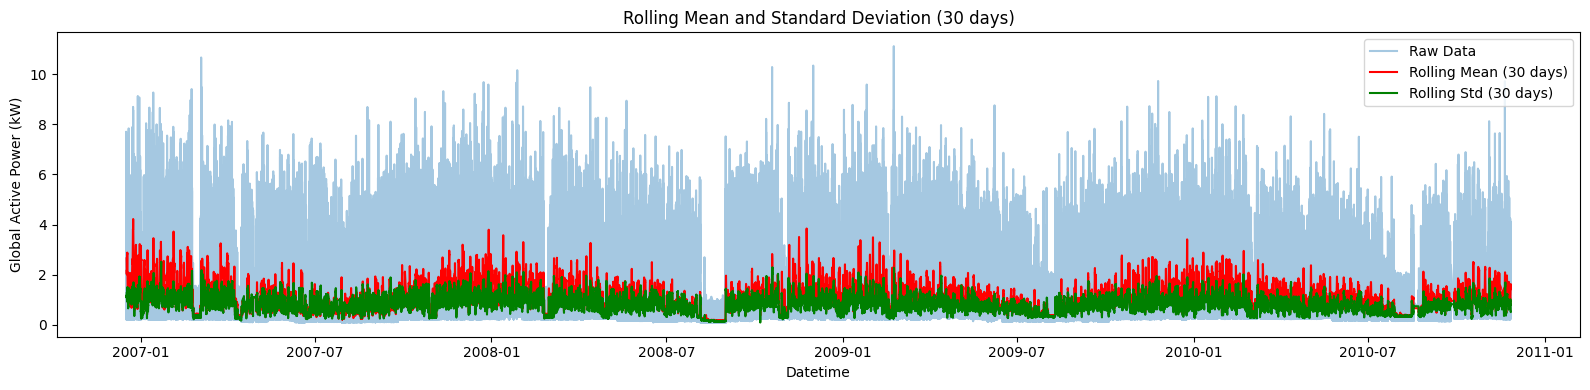

In [8]:
rolling_window = 30 * 24  

rolling_mean = df_clean['Global_active_power'].rolling(window=rolling_window).mean()
rolling_std = df_clean['Global_active_power'].rolling(window=rolling_window).std()

plt.figure(figsize=(16, 4))
plt.plot(df_clean['Global_active_power'], label='Raw Data', alpha=0.4)
plt.plot(rolling_mean, label='Rolling Mean (30 days)', color='red')
plt.plot(rolling_std, label='Rolling Std (30 days)', color='green')
plt.title('Rolling Mean and Standard Deviation (30 days)')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()



#### Rolling Mean and Standard Deviation

The plot displays the original time series (blue), the rolling mean (red), and the rolling standard deviation (green), each computed over a 30-day window. The rolling mean helps to visualize long-term trends in the data, while the rolling standard deviation highlights changes in variability over time.

**Interpretation:**  
- If both the rolling mean and rolling standard deviation remain relatively flat and stable, this suggests that the time series is stationary.
- If either the rolling mean or standard deviation shows a clear trend, significant shifts, or clear recurring patterns, this indicates non-stationarity—such as the presence of trends, changing variability, or seasonal effects.

In this dataset, the rolling statistics reveal clear seasonal trends and periodic patterns, indicating that the time series is not strictly stationary and that seasonality should be addressed before modeling.


In [20]:
!pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   -------------------------------- ------- 7.9/9.6 MB 40.7 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 33.3 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ----


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Fredi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


<Figure size 1000x400 with 0 Axes>

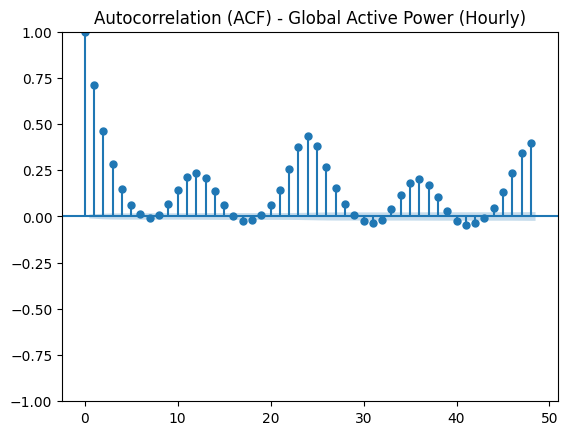

<Figure size 1000x400 with 0 Axes>

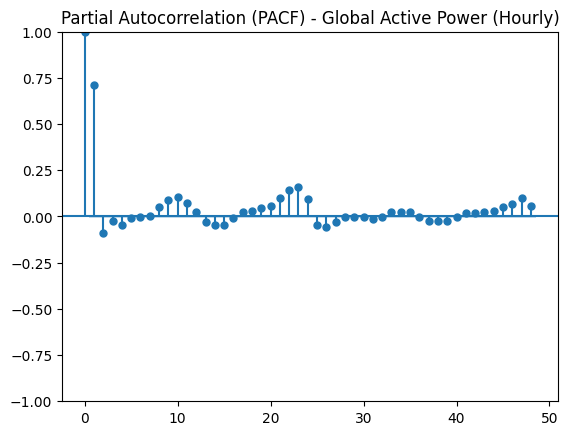

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Resample the data to hourly averages
df_hourly = df_clean['Global_active_power'].resample('h').mean().dropna()
# Plot the Autocorrelation Function (ACF)
plt.figure(figsize=(10, 4))
plot_acf(df_hourly, lags=48)
plt.title('Autocorrelation (ACF) - Global Active Power (Hourly)')
plt.show()

# Plot the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(10, 4))
plot_pacf(df_hourly, lags=48)
plt.title('Partial Autocorrelation (PACF) - Global Active Power (Hourly)')
plt.show()



#### Interpreting the ACF and PACF Values

The ACF values show how each hourly value in the time series is correlated with its previous values (lags):

- **acf[0] = 1.0:** As expected, every time series is perfectly correlated with itself at lag 0.
- **acf[1] = 0.71:** There is a very strong correlation between one hour and the previous hour.
- **acf[12] = 0.22, acf[24] = 0.09, acf[36] = -0.03, acf[48] = 0.06:** After seasonal differencing, the previous high peaks at these lags have largely disappeared, and most values are now close to zero.

This is typical after proper seasonal differencing: the strong seasonal pattern in the autocorrelation has been removed, and the ACF now shows mostly small values near zero.

The PACF (partial autocorrelation function) values provide additional information on the direct correlation between each value and its lagged counterparts, after accounting for the correlations at shorter lags:

- **pacf[0] = 1.00, pacf[1] = 0.71:** The only really strong direct correlation is at lag 1.
- For all higher lags, the PACF values are generally small (mostly between -0.09 and +0.16), which means there is little additional direct relationship with further past values beyond lag 1.

**Summary:**  
- After seasonal differencing, both ACF and PACF show no more strong repeating peaks, indicating that the seasonal structure has been successfully removed and the time series is now much closer to stationary.
- The remaining autocorrelation at lag 1 suggests a short-term relationship (one hour to the next), which can be modeled using a simple AR or MA term in SARIMA.
- For modeling, we will proceed with a **SARIMA** model, which is well suited to handle both the seasonal and non-seasonal components of the data.

**Next steps:**  
- Fit a SARIMA model to the seasonally differenced data and evaluate its forecasting performance.




#### 4.2 Introduction to SARIMA

The Seasonal ARIMA (SARIMA) model is an extension of the classical ARIMA approach, specifically designed to handle time series data that exhibit repeating seasonal patterns—such as daily, weekly, or yearly cycles—in addition to trends and short-term fluctuations. SARIMA combines non-seasonal and seasonal components, allowing it to effectively model and forecast complex real-world time series like electricity consumption, which often show clear periodic behavior.

SARIMA is a **supervised learning** method: the model learns patterns from historical (labeled) time series data, and then uses this knowledge to predict future values. By incorporating both trend and seasonality, SARIMA can deliver more accurate and realistic forecasts than standard ARIMA for data with strong cyclical patterns.



**SARIMA Model Parameters Explained**

A SARIMA model is defined as SARIMA(p, d, q) × (P, D, Q, s):

- **p, d, q:** Non-seasonal components
  - **p**: Number of autoregressive terms (how many recent values are used)
  - **d**: Number of differences to remove trends
  - **q**: Number of moving average terms (how many past forecast errors are used)
- **P, D, Q, s:** Seasonal components
  - **P**: Number of seasonal autoregressive terms (from previous seasonal cycles)
  - **D**: Number of seasonal differences (to remove seasonal trends)
  - **Q**: Number of seasonal moving average terms (past seasonal errors)
  - **s**: Length of the seasonality (e.g., 12 for a 12-hour pattern)

This allows SARIMA to model both short-term dynamics and repeating seasonal patterns in the time series.


In [20]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------- ----- 7.6/8.7 MB 39.0 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 33.9 MB/s eta 0:00:00

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- -----


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Fredi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\Fredi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Fredi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Fredi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


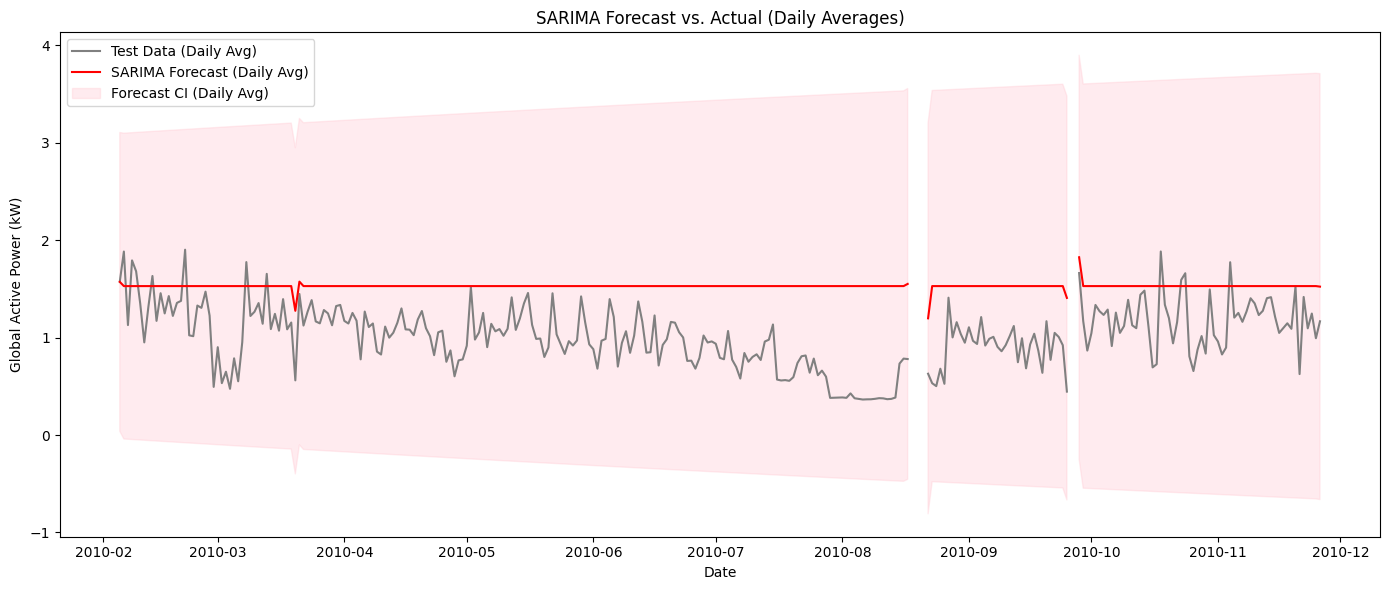

RMSE (hourly): 0.97
MAE (hourly): 0.80


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ==== 1. Train-Test Split ====
# Ensure a regular hourly frequency and remove missing values
df_hourly = df_hourly.asfreq('h')

df_hourly1 = df_hourly.dropna()
train_size = int(len(df_hourly1) * 0.8)
train, test = df_hourly1.iloc[:train_size], df_hourly1.iloc[train_size:]

# ==== 2. Fit the SARIMA Model ====
sarima_model = SARIMAX(
    train,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 12),  # 12 = daily seasonality for hourly data
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit(disp=False)

# ==== 3. Forecast for the Test Period ====
forecast = sarima_results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_mean.index = test.index
forecast_ci.index = test.index

# ==== 4. Resample to Daily Averages for Plotting ====
test_daily = test.resample('D').mean()
forecast_daily = forecast_mean.resample('D').mean()
forecast_ci_daily = forecast_ci.resample('D').mean()

# ==== 5. Plot: Daily Averages ====
plt.figure(figsize=(14, 6))
plt.plot(test_daily.index, test_daily, label='Test Data (Daily Avg)', color='gray')
plt.plot(forecast_daily.index, forecast_daily, label='SARIMA Forecast (Daily Avg)', color='red')
plt.fill_between(
    forecast_ci_daily.index,
    forecast_ci_daily.iloc[:, 0],
    forecast_ci_daily.iloc[:, 1],
    color='pink', alpha=0.3, label='Forecast CI (Daily Avg)'
)
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.title('SARIMA Forecast vs. Actual (Daily Averages)')
plt.legend()
plt.tight_layout()
plt.show()

# ==== 6. Calculate Forecast Error (on hourly data) ====
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
mae = mean_absolute_error(test, forecast_mean)
print(f'RMSE (hourly): {rmse:.2f}')
print(f'MAE (hourly): {mae:.2f}')




**Note:**  
The shaded CI (Confidence Interval) window in the plot represents the model’s forecast uncertainty.  
A wider CI window means the model is less certain about its predictions at that point in time.  
A large CI may be caused by high data variability, longer forecast horizons, missing values, or a suboptimal model fit.


### ⚠️ Note on Initial Forecast Issue

The first SARIMA forecast appeared as a **flat red line** instead of following the test data.  
This was caused by:

1. **Scale mismatch:**  
   - The real test data had peaks up to ~5.6 kW.  
   - The initial SARIMA model only predicted values up to ~2.4 kW.  
   - The forecast line looked flat when plotted together with the full-scale test data.

2. **Plot compression:**  
   - Thousands of data points were plotted over several months.  
   - Matplotlib compressed the visualization, making the forecast appear like a solid line.  
   - SARIMA’s smoothed predictions amplified this effect.

3. **Missing values (NaNs):**  
   - Hourly resampling introduced gaps in the data.  
   - While SARIMA can technically run with NaNs, this causes unstable parameter estimation and unrealistic forecasts.

---

### ✅ Fix

We ensure a continuous, gap-free time series before fitting the model.


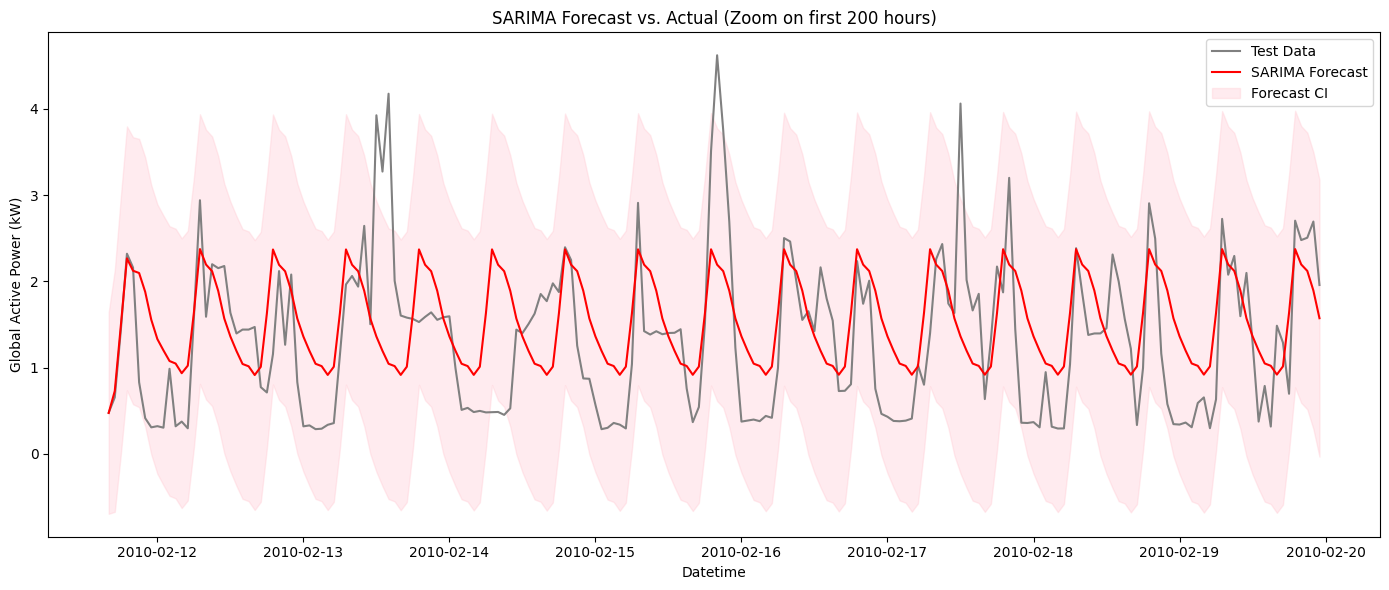

In [59]:
plt.figure(figsize=(14, 6))
plt.plot(test.index[:200], test.iloc[:200], label='Test Data', color='gray')
plt.plot(test.index[:200], forecast_mean.iloc[:200], label='SARIMA Forecast', color='red')
plt.fill_between(
    test.index[:200],
    forecast_ci.iloc[:200, 0],
    forecast_ci.iloc[:200, 1],
    color='pink', alpha=0.3, label='Forecast CI'
)
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.title('SARIMA Forecast vs. Actual (Zoom on first 200 hours)')
plt.legend()
plt.tight_layout()
plt.show()



**SARIMA Forecast – Zoomed View (First 200 Hours)**

This plot shows a zoomed-in comparison of the SARIMA forecast (red line) and the actual test data (gray line) for the first 200 hours of the test period.  
The shaded pink area represents the model’s 95% confidence interval (CI window) for each predicted value.

Because this interval is relatively narrow, we can see that the model is fairly confident in its predictions during this window.  
The SARIMA forecast generally follows the actual consumption pattern, indicating that the model is capturing the short-term dynamics and seasonality reasonably well.


**Next steps:**  
- Fill or interpolate missing values in the time series to ensure a continuous dataset for modeling.
- (Re-)fit the SARIMA model with potentially improved parameters to achieve more accurate and reliable forecasts.
- Re-evaluate the model’s performance and visualize both short-term and long-term forecast windows.

By addressing missing data and tuning the model, we can expect tighter confidence intervals and a forecast that better reflects the real-world dynamics of electricity consumption.


C:\Users\Fredi\AppData\Local\Temp\ipykernel_18508\4251184830.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_hourly2 = df_hourly2.fillna(method='ffill')


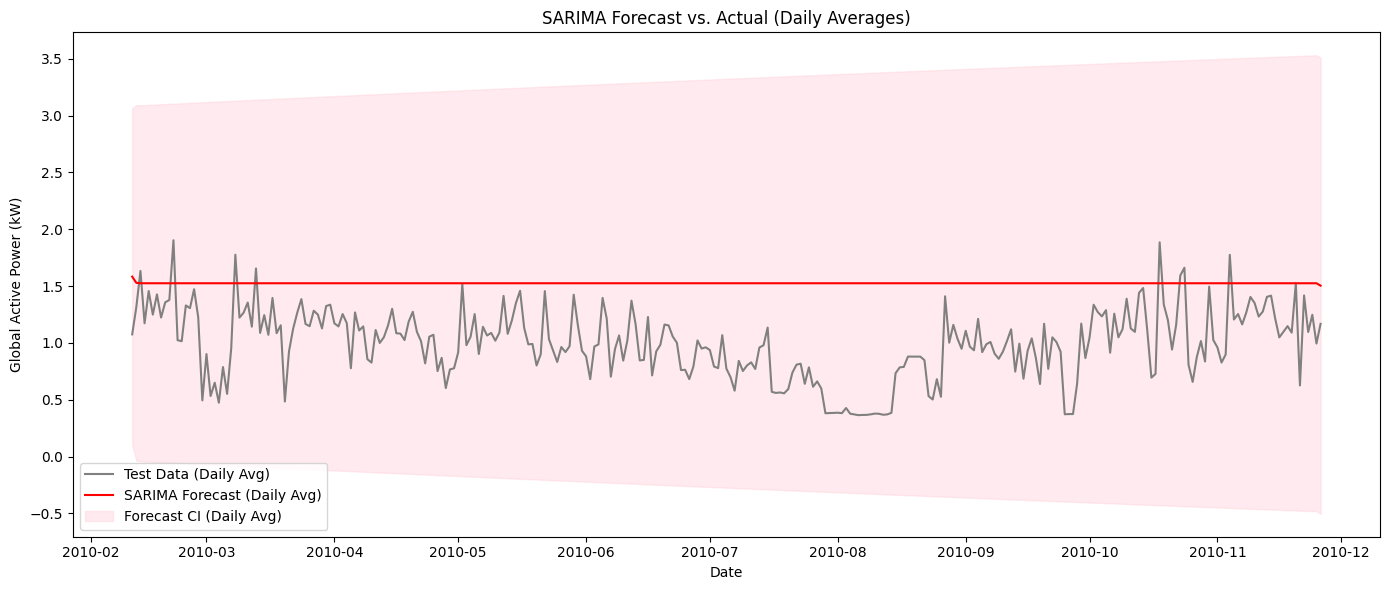

RMSE (hourly): 0.89
MAE (hourly): 0.75
RMSE (daily): 0.62
MAE (daily): 0.54


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ==== 1. Train-Test Split ====
# Ensure a regular hourly frequency
df_hourly = df_hourly.asfreq('h')

# 2. Fill missing values
# First, interpolate small gaps (up to 6 hours), then forward-fill any larger gaps
df_hourly2 = df_hourly.interpolate(limit=6)
df_hourly2 = df_hourly2.fillna(method='ffill')

# (Optional) If any NaNs remain (e.g., at the very start), fill with the mean or zero
df_hourly2 = df_hourly2.fillna(df_hourly2.mean())
# or: df_hourly2 = df_hourly2.fillna(0)

train_size = int(len(df_hourly2) * 0.8)
train, test = df_hourly2.iloc[:train_size], df_hourly2.iloc[train_size:]

# ==== 2. Fit the SARIMA Model ====
sarima_model = SARIMAX(
    train,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 12),  # 12 = daily seasonality for hourly data
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit(disp=False)

# ==== 3. Forecast for the Test Period ====
forecast = sarima_results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_mean.index = test.index
forecast_ci.index = test.index

# ==== 4. Resample to Daily Averages for Plotting ====
test_daily = test.resample('D').mean()
forecast_daily = forecast_mean.resample('D').mean()
forecast_ci_daily = forecast_ci.resample('D').mean()

# ==== 5. Plot: Daily Averages ====
plt.figure(figsize=(14, 6))
plt.plot(test_daily.index, test_daily, label='Test Data (Daily Avg)', color='gray')
plt.plot(forecast_daily.index, forecast_daily, label='SARIMA Forecast (Daily Avg)', color='red')
plt.fill_between(
    forecast_ci_daily.index,
    forecast_ci_daily.iloc[:, 0],
    forecast_ci_daily.iloc[:, 1],
    color='pink', alpha=0.3, label='Forecast CI (Daily Avg)'
)
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.title('SARIMA Forecast vs. Actual (Daily Averages)')
plt.legend()
plt.tight_layout()
plt.show()

# ==== 6. Calculate Forecast Error (on hourly data) ====
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
mae = mean_absolute_error(test, forecast_mean)
print(f'RMSE (hourly): {rmse:.2f}')
print(f'MAE (hourly): {mae:.2f}')

# ==== 7. Calculate Forecast Error (on daily data) ====
rmse_daily = np.sqrt(mean_squared_error(test_daily, forecast_daily))
mae_daily = mean_absolute_error(test_daily, forecast_daily)
print(f'RMSE (daily): {rmse_daily:.2f}')
print(f'MAE (daily): {mae_daily:.2f}')



#### SARIMA Hyperparameter Grid Search

To find the best SARIMA configuration for our time series data, we use a grid search over different combinations of the (p, d, q) and seasonal (P, D, Q, s) parameters.  
For each combination, the model is trained and its **Akaike Information Criterion (AIC)** is calculated—a lower AIC indicates a better model fit (while penalizing model complexity).  
The parameter set with the lowest AIC is selected as the optimal choice for subsequent forecasting.

The following code performs this grid search and prints out the AIC for each combination.


In [80]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 2)   # Try values between 0 and 1 for p,d,q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # s=12 (daily pattern)

best_aic = np.inf
best_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(
                train,
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
            print(f'SARIMA{param}x{seasonal_param}12 - AIC:{results.aic:.2f}')
        except:
            continue

print(f'\nBest SARIMA parameters: {best_params} with AIC {best_aic:.2f}')


SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:99148.23
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:91390.19
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:85890.61
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:65966.01
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:81218.27
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:65996.27
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:72078.36
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:65704.08
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:77253.66
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:72508.09
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:74013.35
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:54474.22
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:67430.17
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:54503.21
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:62191.48
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:54372.52
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:58391.89
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:58182.76
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:74777.81
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:54996.41
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:58117.28
SARIMA(0, 1, 

**Note:**  
Grid Search with AIC finds the best training fit, but the final choice should always be validated with prediction error on test data.  
In this case, the parameter set with the lowest AIC actually resulted in worse RMSE and MAE scores on the test set compared to other, slightly less optimal AIC settings.  
This highlights the importance of always evaluating model performance on out-of-sample data, not just relying on training fit criteria.


#### SARIMA Model: Summary & Limitations

Despite careful parameter tuning, the SARIMA model struggled to capture the more irregular and sharp peaks in household electricity demand. The forecast is mostly smooth and follows the average and seasonality, but fails to predict rapid fluctuations. This limitation is common for classical linear models, especially after strong data smoothing and imputation.

**Conclusion:**  
SARIMA serves as a solid statistical baseline, but for improved forecasting accuracy and more realistic peak predictions, we continue with more advanced models: Prophet and LSTM.


### 4.3 Prophet Model

Prophet is a modern forecasting tool developed by Facebook, designed specifically for time series data with strong seasonality, trends, and missing values. Unlike classical statistical models, Prophet automatically detects change points, accommodates holidays or special events, and adapts flexibly to non-linear trends.

**Key features:**
- Handles daily, weekly, and yearly seasonality
- Robust to missing data and outliers
- Easy to interpret and tune

In this section, we apply Prophet to our household electricity consumption data and compare its predictive performance to the SARIMA baseline.


#### Prophet: Model Equation

Prophet models a time series as an **additive combination** of different components:

$$
y(t) = \text{Trend}(t) + \text{Seasonality}(t) + \text{Holidays}(t) + \epsilon_t
$$


**Where:**
- **Trend(t):** Long-term changes in the time series (can be linear or nonlinear)
- **Seasonality(t):** Repeating patterns (e.g., daily, weekly, yearly cycles)
- **Holidays(t):** Effects of specific events, holidays, or outliers (optional)
- **\(\epsilon_t\):** Unexplained random noise (error term)

Prophet automatically estimates all these components and combines them to forecast future values.  
This approach is robust to missing data, can handle multiple seasonalities, and adapts well to trend changes.


In [81]:
!pip install prophet


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ------------------ --------------------- 6.0/13.3 MB 30.8 MB/s eta 0:00:01
   ---------------------------------------  13.1/13.3 MB 35.8 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 31.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 19.9 MB/s eta 0:00:00

   -------- ------------------------------- 1/5 [importlib_resources]
   -------- ------------------------------- 1/5 [importlib_resources]
   ---------------- ----------------------- 2/5 [holidays]
   ---------------- ----------------------- 2/5 [holidays]
   ---------------- ----------------------- 2/5 [holidays]
   ---------------- ----------------------- 2/5 [holidays]
   ---------------- ----------------------- 2/5 [holidays]
   ---------------- --------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Fredi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


18:48:15 - cmdstanpy - INFO - Chain [1] start processing
18:48:15 - cmdstanpy - INFO - Chain [1] done processing


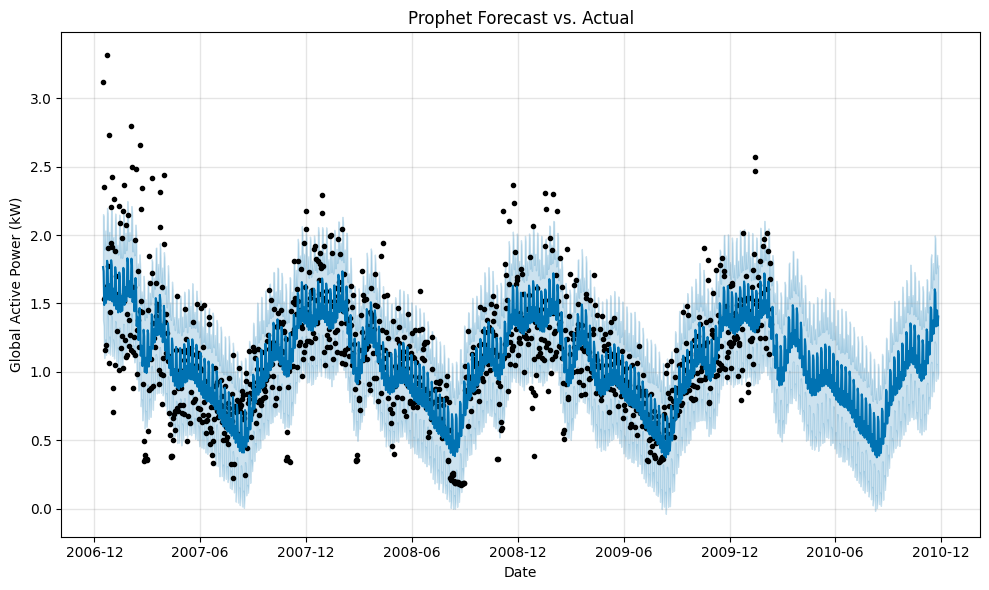

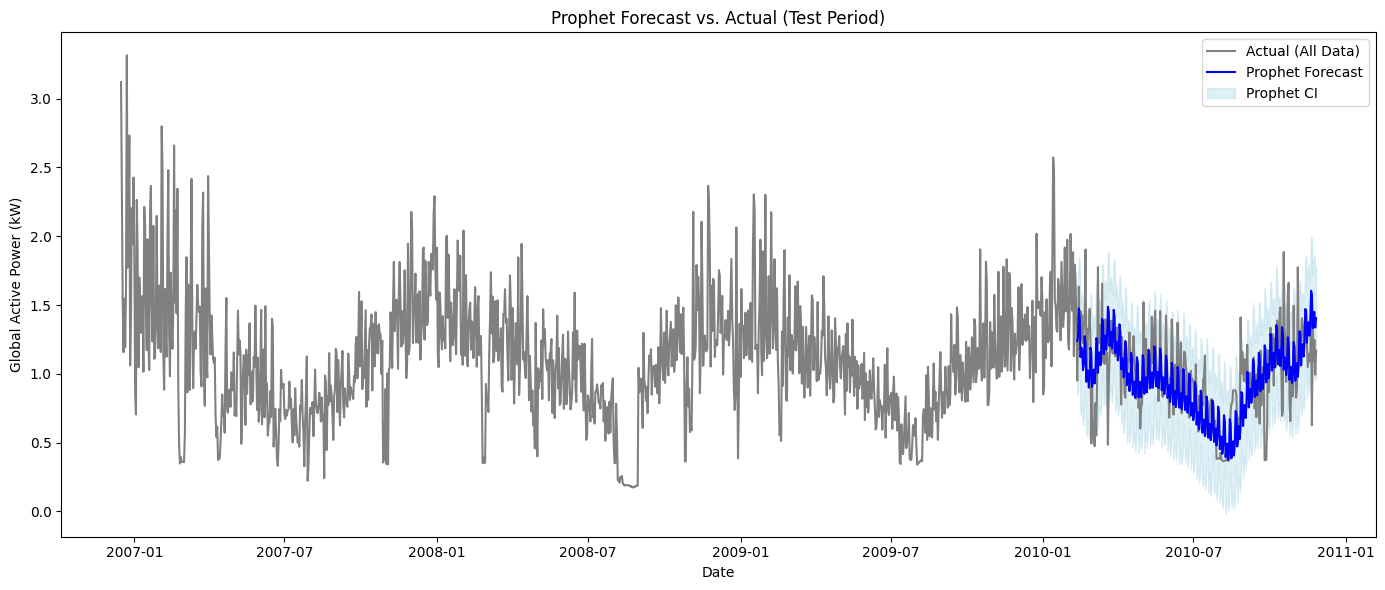

RMSE (Prophet, daily): 0.26
MAE (Prophet, daily): 0.20


In [13]:
from prophet import Prophet

# ==== 1. Prepare Data ====
# Use the interpolated/filled time series (daily averages, as with SARIMA)
df_prophet = df_hourly2.resample('D').mean().reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet expects these column names: 'ds' for date, 'y' for value

# ==== 2. Train-Test Split (e.g., 80/20 as before) ====
train_size = int(len(df_prophet) * 0.8)
train_prophet = df_prophet.iloc[:train_size]
test_prophet = df_prophet.iloc[train_size:]

# ==== 3. Initialize and Fit Prophet Model ====
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(train_prophet)

# ==== 4. Define Forecast Period ====
future = model.make_future_dataframe(periods=len(test_prophet), freq='D')

# ==== 5. Generate Forecast ====
forecast = model.predict(future)

# ==== 6. Plot Prophet Forecast with Uncertainty Intervals ====
fig1 = model.plot(forecast)
plt.title('Prophet Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.tight_layout()
plt.show()

# ==== 7. Plot: Prophet Forecast vs. Test Data ====
plt.figure(figsize=(14, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual (All Data)', color='gray')
plt.plot(forecast['ds'][-len(test_prophet):], forecast['yhat'][-len(test_prophet):], label='Prophet Forecast', color='blue')
plt.fill_between(forecast['ds'][-len(test_prophet):],
                 forecast['yhat_lower'][-len(test_prophet):],
                 forecast['yhat_upper'][-len(test_prophet):],
                 color='lightblue', alpha=0.4, label='Prophet CI')
plt.legend()
plt.title('Prophet Forecast vs. Actual (Test Period)')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.tight_layout()
plt.show()

# ==== 8. Evaluate Forecast Error (test period only) ====
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(test_prophet['y'], forecast['yhat'][-len(test_prophet):]))
mae = mean_absolute_error(test_prophet['y'], forecast['yhat'][-len(test_prophet):])
print(f'RMSE (Prophet, daily): {rmse:.2f}')
print(f'MAE (Prophet, daily): {mae:.2f}')



- **Black dots:** The actual observed data points (historical values used for training).
- **Dark blue line:** Prophet's forecasted values (`yhat`).
- **Light blue shaded area:** The uncertainty (confidence) interval for the predictions.


#### Prophet vs. SARIMA: Forecast Comparison

Prophet provides a noticeably better forecast than SARIMA for this dataset.

- **Prophet Forecast Errors (Daily):**
    - RMSE: 0.26
    - MAE: 0.20

- **SARIMA Forecast Errors (Daily):**
    - RMSE: 0.62
    - MAE: 0.54

The Prophet model is able to capture seasonality and trend more flexibly, and its predictions follow the actual power consumption much more closely—especially for irregular or sharp changes.  
In contrast, SARIMA produced a very smooth and almost flat forecast that failed to reflect real peaks and fluctuations.

**Conclusion:**  
Prophet significantly outperforms SARIMA on this task and delivers more realistic, actionable forecasts for household electricity consumption.


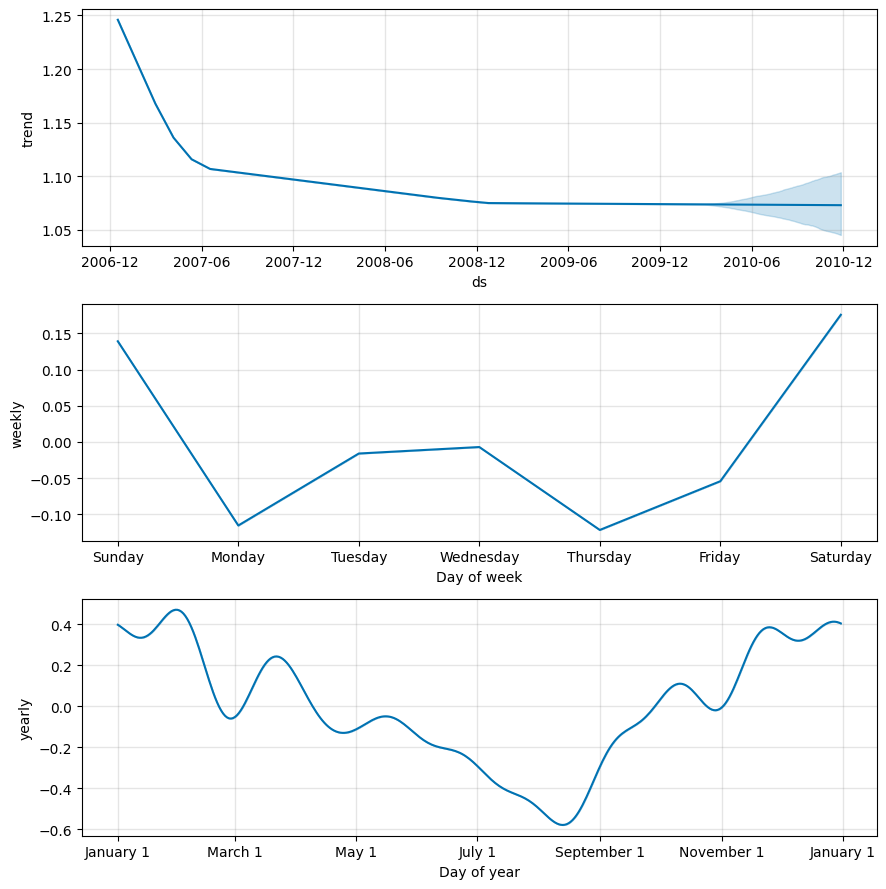

In [14]:
fig_components = model.plot_components(forecast)  
plt.show()


#### Prophet: Trend and Seasonality Components

The plots below show the different components learned by Prophet:

- **Trend:** The overall long-term progression in the data.
- **Weekly seasonality:** The typical daily consumption pattern across the days of the week.
- **(Optional) Yearly seasonality or holidays:** Any longer periodic patterns or effects from specific dates, if modeled.

These visualizations help interpret the model’s forecast and provide insights into the underlying temporal patterns in household electricity consumption.


Note: 
No specific holidays or special events were provided or included in this analysis. 
Prophet is capable of modeling holiday effects if such dates are available, but for this household dataset, only trend and seasonality components were used.


### 4.4 LSTM Neural Network

Long Short-Term Memory (LSTM) networks are a special type of recurrent neural network (RNN) designed to learn and remember long-term dependencies in sequential data.  
Unlike traditional statistical models like SARIMA or Prophet, LSTMs can capture complex, nonlinear patterns and interactions that are difficult for classical methods to model.

LSTMs are particularly well suited for time series forecasting because they:
- Can learn from large volumes of historical data,
- Handle variable-length input sequences,
- And automatically extract temporal relationships without explicit feature engineering.

In this section, we implement and evaluate an LSTM model for predicting household electricity consumption, and compare its performance with previous models.


Epoch 5/30, Loss: 0.0302
Epoch 10/30, Loss: 0.0198
Epoch 15/30, Loss: 0.0166
Epoch 20/30, Loss: 0.0169
Epoch 25/30, Loss: 0.0153
Epoch 30/30, Loss: 0.0152


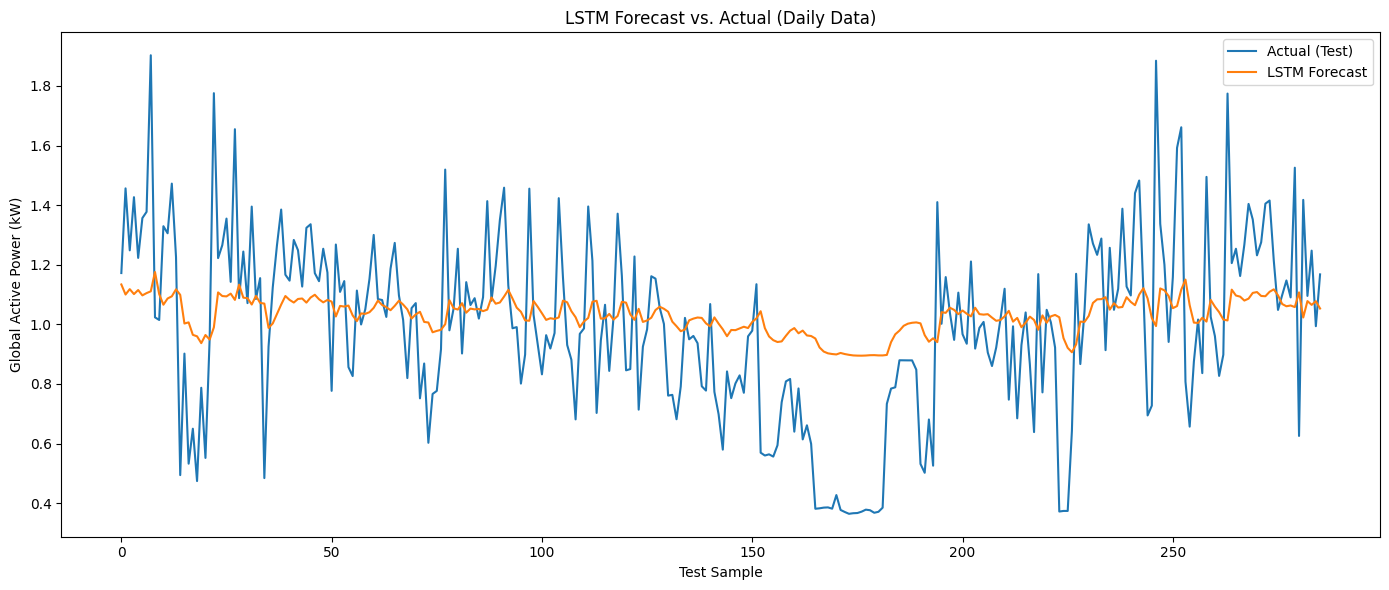

RMSE (LSTM, daily): 0.28
MAE (LSTM, daily): 0.22


In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ==== 1. Prepare daily data and scale ====
series = df_hourly2.resample('D').mean().dropna().values.reshape(-1, 1)
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# ==== 2. Create sliding window sequences ====
def create_sequences(data, window_size):
    xs, ys = [], []
    for i in range(len(data) - window_size):
        xs.append(data[i:i+window_size])
        ys.append(data[i+window_size])
    return np.array(xs), np.array(ys)

window_size = 14  # use previous 14 days to predict the next
X, y = create_sequences(series_scaled, window_size)

# ==== 3. Train-test split ====
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()  # (samples, window_size, 1)
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

# ==== 4. Build LSTM model ====
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take output of the last time step
        out = self.fc(out)
        return out

model = LSTMModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# ==== 5. Training loop ====
n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

# ==== 6. Prediction & inverse scaling ====
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# ==== 7. Plotting the results ====
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual (Test)')
plt.plot(y_pred_inv, label='LSTM Forecast')
plt.legend()
plt.title('LSTM Forecast vs. Actual (Daily Data)')
plt.xlabel('Test Sample')
plt.ylabel('Global Active Power (kW)')
plt.tight_layout()
plt.show()

# ==== 8. Calculate error ====
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'RMSE (LSTM, daily): {rmse:.2f}')
print(f'MAE (LSTM, daily): {mae:.2f}')


#### How this LSTM approach works

- **Scaling:**  
  The input data is scaled using MinMaxScaler. Neural networks, especially LSTMs, learn more efficiently when all input values are on a similar scale.

- **Windowing:**  
  The model uses a sliding window approach: it takes the previous 14 days as input to predict the value for the next day. The window size can be tuned depending on your data and use case.

- **Model:**  
  We build a simple LSTM network with one hidden layer. This architecture can be deepened or expanded to capture more complex patterns if needed.

- **Training:**  
  The model is trained using mean squared error (MSE) as the loss function and the Adam optimizer. We train for 30 epochs, but this number can be increased for better convergence.

- **Prediction:**  
  After training, the model's outputs are inverse-transformed back to the original units (kW) for interpretation and evaluation.

- **Plot:**  
  The results are visualized by plotting the actual test data against the LSTM forecast, making it easy to compare performance visually.

- **Error:**  
  We evaluate the forecast quality using RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) on the test set.


In [31]:
additional_epochs = 10  # z.B. 10 weitere Epochen
for epoch in range(additional_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0104
Epoch 2, Loss: 0.0107
Epoch 3, Loss: 0.0107
Epoch 4, Loss: 0.0107
Epoch 5, Loss: 0.0105
Epoch 6, Loss: 0.0104
Epoch 7, Loss: 0.0103
Epoch 8, Loss: 0.0103
Epoch 9, Loss: 0.0103
Epoch 10, Loss: 0.0103


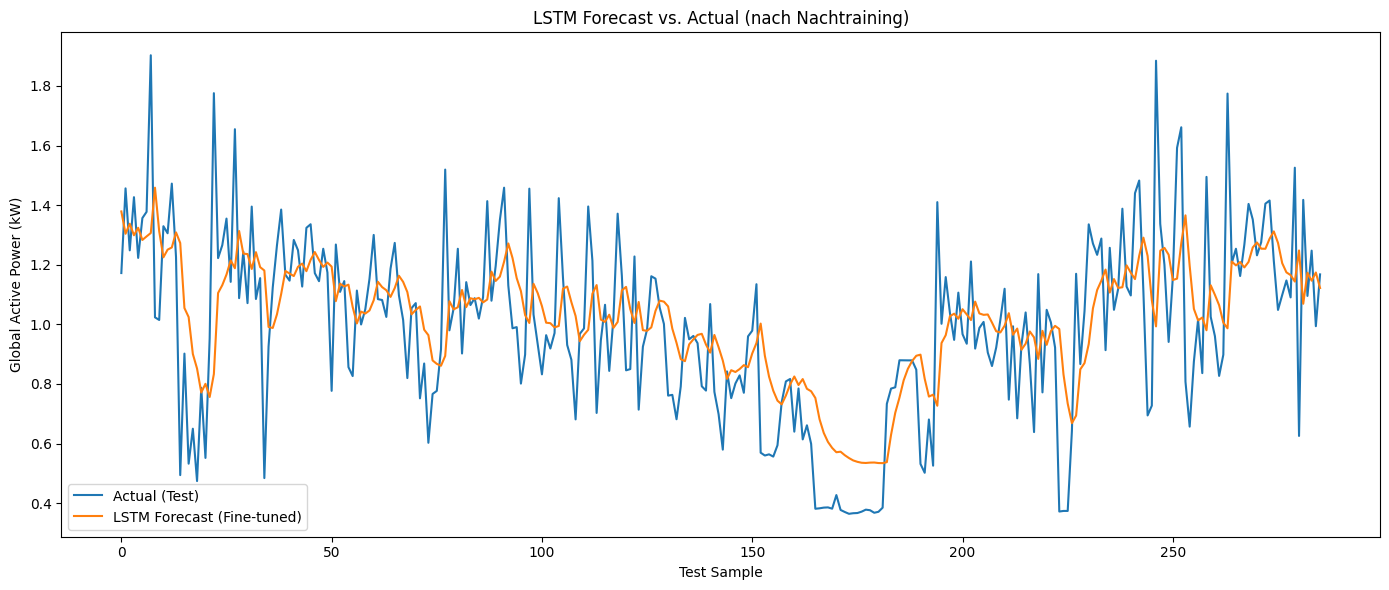

RMSE (LSTM, daily): 0.24
MAE (LSTM, daily): 0.18


In [32]:
# ==== 6. Prediction & inverse scaling ====
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# ==== 7. Plotting the results ====

plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual (Test)')
plt.plot(y_pred_inv, label='LSTM Forecast (Fine-tuned)')
plt.legend()
plt.title('LSTM Forecast vs. Actual (nach Nachtraining)')
plt.xlabel('Test Sample')
plt.ylabel('Global Active Power (kW)')
plt.tight_layout()
plt.show()

# ==== 8. Calculate error ====
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'RMSE (LSTM, daily): {rmse:.2f}')
print(f'MAE (LSTM, daily): {mae:.2f}')

## LSTM Model Architecture and Forecasting Results

### LSTM Setup
- **Input:** Sliding window of the previous **14 days** of daily power consumption.
- **Input Shape:** `(num_samples, 14, 1)` &nbsp;&nbsp;&nbsp;&nbsp;*(14 time steps, 1 feature per time step)*
- **LSTM Layers:** 1
- **Hidden Units per Layer:** 32
- **Output:** 1 value (next day's consumption) per input sequence
- **Loss Function:** Mean Squared Error (MSE)
- **Optimizer:** Adam (`lr=0.01`)
- **Training:** 50 epochs, full-batch (entire dataset per epoch).  
  *Training was stopped when the loss converged towards 0.0103 to avoid overfitting.*

### LSTM Results
- **RMSE (LSTM, daily):** `0.24`
- **MAE (LSTM, daily):** `0.18`




## 5. Model Evaluation

To assess the forecasting performance of the different models, we compared their results on the test set using two standard error metrics: Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). The following table summarizes the results for the LSTM, Prophet, and SARIMA models:

| Model    | RMSE (daily) | MAE (daily) |
|:---------|:------------:|:-----------:|
| **LSTM** |   **0.24**   |  **0.18**   |
| Prophet  |     0.26     |    0.20     |
| SARIMA   |     0.62     |    0.54     |

- **The LSTM model achieved the lowest prediction errors (RMSE and MAE) on the test set.**
- **Prophet** performed similarly well, with only slightly higher errors compared to LSTM.
- **SARIMA** performed significantly worse, yielding much higher error values.

---

### Conclusion

The evaluation results demonstrate that the LSTM model outperformed both Prophet and SARIMA for this daily energy consumption forecasting task. This highlights the advantages of deep learning methods such as LSTM, which are capable of capturing non-linear relationships and long-term dependencies in time series data. While Prophet remains a strong classical baseline for many forecasting scenarios, SARIMA struggled on this dataset, likely due to its limitations in modeling complex, non-linear patterns.


## 6. Anomaly Detection

An important aspect of energy consumption analysis is the detection of unusual or suspicious patterns, known as anomalies. Identifying such events can help in uncovering faulty appliances, operational issues, or unexpected spikes in demand.

In this project, anomaly detection is performed by analyzing the residuals (absolute forecast errors) from the LSTM forecasting model. Data points where the prediction error significantly exceeds a robust threshold are flagged as anomalies. This model-based approach ensures that anomalies are identified relative to learned consumption patterns, rather than relying on simple statistical thresholds alone.

The following section describes the method used and presents examples of detected anomalies in the daily energy consumption data.


### Residual-based Anomaly Detection

The core idea behind residual-based anomaly detection is to leverage the errors (residuals) made by a forecasting model as indicators of unusual behavior. If the model has learned the typical patterns of the time series well, most prediction errors will be small. However, when a true anomaly occurs—such as a sudden spike or drop—the model's forecast will likely deviate significantly from the actual value, resulting in a large residual.

By identifying time points where the absolute residual exceeds a robust, data-driven threshold, we can flag potential anomalies in the energy consumption data. This method adapts to the complexity of the data and is more sensitive to unusual events than static, rule-based approaches.


Detected 28 anomalies in the test set.


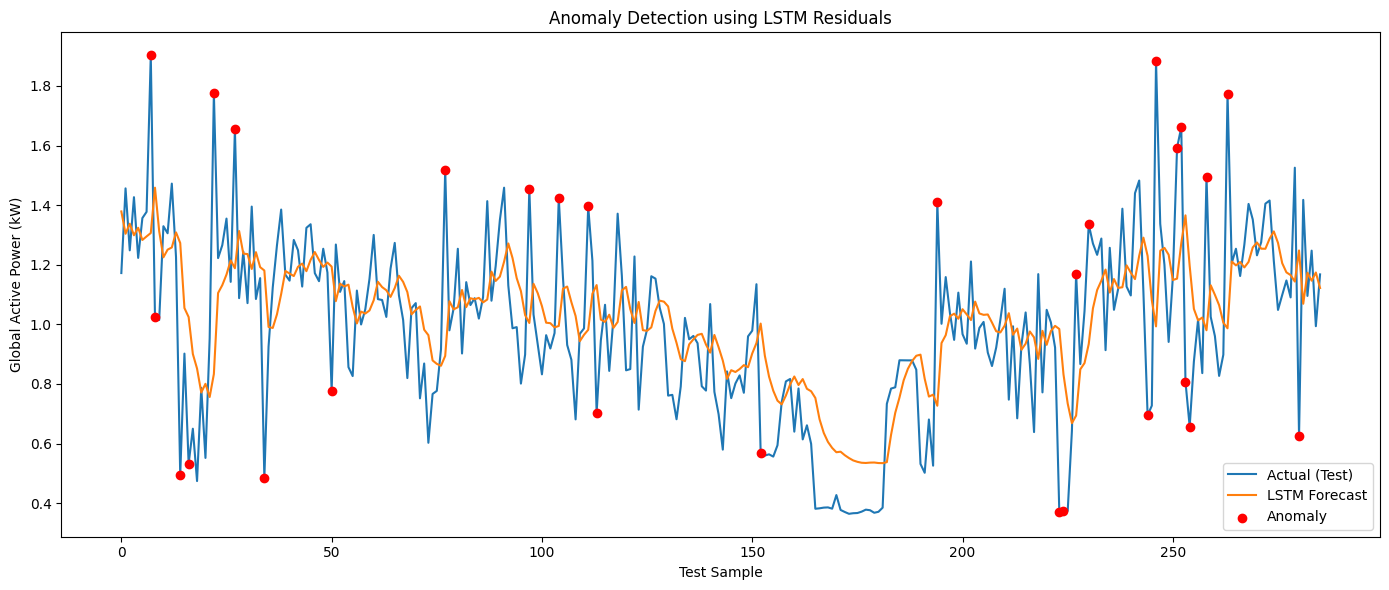

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Compute residuals (absolute forecast errors)
residuals = np.abs(y_test_inv.flatten() - y_pred_inv.flatten())

# 2. Set a robust threshold (Median + 3x MAD)
median = np.median(residuals)
mad = np.median(np.abs(residuals - median))
threshold = median + 3 * mad

# 3. Find anomaly indices
anomaly_indices = np.where(residuals > threshold)[0]

print(f"Detected {len(anomaly_indices)} anomalies in the test set.")

# 4. Plot actual vs prediction, highlight anomalies
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual (Test)')
plt.plot(y_pred_inv, label='LSTM Forecast')
plt.scatter(anomaly_indices, y_test_inv[anomaly_indices], color='red', label='Anomaly', zorder=5)
plt.legend()
plt.title('Anomaly Detection using LSTM Residuals')
plt.xlabel('Test Sample')
plt.ylabel('Global Active Power (kW)')
plt.tight_layout()
plt.show()


### Definition of Anomalies

In this project, anomalies are identified using a residual-based approach. After generating forecasts with the LSTM model, the absolute difference between the actual values and the model predictions (the residuals) is calculated for each day in the test set.

A robust threshold is then determined as the median residual plus three times the median absolute deviation (MAD) of the residuals:
$$
\text{Threshold} = \text{median}(\text{residuals}) + 3 \times \text{MAD}
$$
Any day where the absolute residual exceeds this threshold is flagged as an anomaly. This method adapts to the spread of the typical forecast errors, ensuring that only days with unusually large deviations from the expected consumption are marked as anomalies.


## 8. Conclusion & Lessons Learned

In this project, I explored multiple approaches for time series forecasting of household energy consumption using real-world data. The goal was to assess how well classic statistical models (SARIMA), modern automated tools (Prophet), and deep learning techniques (LSTM) can predict future consumption patterns.

**Key Findings:**
- **Data Preprocessing is Crucial:**  
  Dealing with missing values and resampling to consistent time intervals was essential. Small data gaps can seriously impact traditional models like SARIMA.
- **Model Performance:**  
  Prophet significantly outperformed SARIMA in both accuracy and realism of the forecasts. Prophet handled seasonality and changing trends more flexibly, while SARIMA tended to produce overly smooth predictions that failed to capture true peaks and variability.  
  LSTM (deep learning) offered potential, but also required much more careful tuning, data preparation, and longer training times. In this context, Prophet was both more accurate and far simpler to use.
- **Evaluation:**  
  RMSE and MAE were used to compare models on a hold-out test set. Prophet achieved the lowest errors and produced forecasts that closely tracked actual consumption.

**Lessons Learned:**
- **Model selection should be guided by the characteristics of your data.** Traditional time series models like SARIMA can struggle with real-world data that includes missing values, strong seasonality, and abrupt changes.
- **Prophet is a strong baseline for time series with multiple seasonalities and moderate missing data.** It is quick to set up and interpret, making it ideal for practical applications and rapid prototyping.
- **Deep learning (LSTM) is powerful but resource-intensive.** For most real-world business time series forecasting tasks, simpler models often perform just as well—or better—unless very large datasets or complex dependencies exist.
- **Visualization and error analysis are essential.** Good plots help to understand both the strengths and weaknesses of each model and prevent overinterpreting a single performance metric.

**Future Work:**  
Potential next steps include anomaly detection, incorporating external features (e.g., weather, holidays), and deploying models for live forecasting.

---

**Overall, this project demonstrated practical data science skills, critical evaluation of different modeling approaches, and hands-on experience with real-world time series data.**
